In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string

import nltk    # Important library with many useful methods for natural language processing 
#nltk.download('stopwords') 
# download stopwords in english to be used later, use this if you have not done so before

import pandas as pd
from nltk.corpus import stopwords
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## For this challenge, I did not follow the route of building a NN, instead used XGBOOST Classifier utilizing a bag of words (BoW) approach and pre-processing the text messages following the tools presented [here](https://blog.paperspace.com/nlp-spam-detection-application-with-scikitlearn-xgboost/) 

In [2]:
# get data files
#!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
#!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

## Load and Explore the data set, splitting is done for us

In [3]:
train_dataset = pd.read_csv('train-data.tsv', sep='\t', header = None)
test_dataset = pd.read_csv('valid-data.tsv', sep='\t', header = None)

In [4]:
test_dataset.head()

,0,1
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
# Rename the columns as they appear as 0 for the class and 1 for the sms messages 

train_dataset = train_dataset.rename(columns = {0:'class',1:'sms'})
test_dataset = test_dataset.rename(columns = {0:'class',1:'sms'})

In [6]:
test_dataset.head()

,class,sms
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
train_dataset.head()

,class,sms
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [8]:
print(" Total number of text messages is: ", len(train_dataset) + len(test_dataset))

 Total number of text messages is:  5571


In [9]:
train_dataset['class'].value_counts() # number of ham vs spam in the training set

ham     3619
spam     560
Name: class, dtype: int64

In [10]:
test_dataset['class'].value_counts() # number of ham vs spam in the test set

ham     1205
spam     187
Name: class, dtype: int64

In [11]:
# Lets compare the length of ham and spam messages in the training data set 

train_dataset['length'] = train_dataset['sms'].apply(len)
train_dataset.head()

,class,sms,length
0,ham,ahhhh...just woken up!had a bad dream about u ...,146
1,ham,you can never do nothing,24
2,ham,"now u sound like manky scouse boy steve,like! ...",115
3,ham,mum say we wan to go then go... then she can s...,83
4,ham,never y lei... i v lazy... got wat? dat day ü ...,77


<AxesSubplot:ylabel='Frequency'>

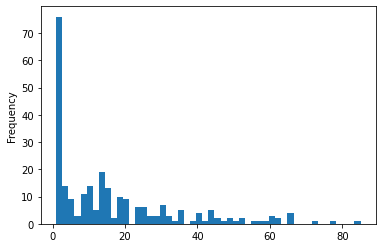

In [12]:
train_dataset['length'].value_counts().plot(bins = 50, kind = 'hist')

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

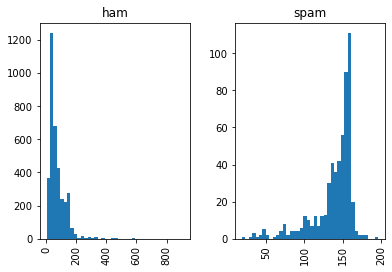

In [13]:
train_dataset.hist(column = 'length', by = 'class', bins = 40)

In [ ]:
# Length of spam vs ham differs considerably, it could be actually used as a good feature to distinguish?
# But we will drop it as we will utilize BoW approach 

In [14]:
train_dataset = train_dataset.drop('length', axis = 1)
train_dataset.head()

,class,sms
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [15]:
train_dataset['sms'][4]

'never y lei... i v lazy... got wat? dat day ü send me da url cant work one...'

In [ ]:
# We see that there are punctuations in the text messages, we can define a text pre processor to remove them
# We can also remove any non-alphabetic characters in a text message using .isalpha() method of string library

# Finally, we can also remove the 'stop words', that are commonly used in a sentence, 'is', 'are' , 'a', since they
# are commonly used but carry no useful information. This is especially the case if one uses Bag of Words approach,
# which essentially counts the number of occurance of a word in a text. In this approach, 
# stop words assigned a greater frequency than the informational words and may pose a problem for the 
# predictions in a ML model 

In [ ]:
# Define a sms pre-processor below to remove punctuations, non-alphabetic characters and stopwords

In [16]:
def smspp(sms):
    
    remove_punc = []
    
    for char in sms:
        if char not in string.punctuation:
            remove_punc.append(char)
    # remove_punc is a list of characters that is not a punctuation: i.e ?,!,. etc, so we need to join the 
    # characters again to compile the sms text, next we lower all the characters
    
    remove_punc = ''.join(remove_punc)
    remove_punc = remove_punc.lower()
    
    # Finally we can remove the stop_words (sw) and non-alphabetic characters (nac), for the stop words we will use 
    
    
    rem_sw_and_nac = []
    for word in remove_punc.split():
        if word.isalpha() and word.lower() not in stopwords.words('english'):
            rem_sw_and_nac.append(word)
            
    return rem_sw_and_nac # returns a list of words that are non stop_words and alphabetic
        

In [ ]:
# Test our sms pre-processor 

In [17]:
smspp('I am going to get 3 apples.')

['going', 'get', 'apples']

In [18]:
train_dataset['sms'][0]

'ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.'

In [19]:
smspp(train_dataset['sms'][0])

['ahhhhjust',
 'woken',
 'uphad',
 'bad',
 'dream',
 'u',
 'thoso',
 'dont',
 'like',
 'u',
 'right',
 'didnt',
 'know',
 'anything',
 'comedy',
 'night',
 'guess',
 'im']

In [ ]:
# In order to return the sms messages that are labeled as ham or spam we use the following syntax

In [20]:
train_dataset['class'] == 'ham'

0        True
1        True
2        True
3        True
4        True
        ...  
4174     True
4175     True
4176    False
4177    False
4178     True
Name: class, Length: 4179, dtype: bool

In [21]:
train_dataset['class'] == 'spam'

0       False
1       False
2       False
3       False
4       False
        ...  
4174    False
4175    False
4176     True
4177     True
4178    False
Name: class, Length: 4179, dtype: bool

In [22]:
ham_msg = train_dataset[train_dataset['class'] == 'ham']['sms']

In [23]:
spam_msg = train_dataset[train_dataset['class'] == 'spam']['sms']

In [24]:
print('Total number of ham messages in the training set:', len(ham_msg))

Total number of ham messages in the training set: 3619


In [25]:
print('Total number of spam messages in the training set:', len(spam_msg))

Total number of spam messages in the training set: 560


In [26]:
# Let's look at common words in spam and ham messages in the training data set

spam_words = []
ham_words = []

for msg in ham_msg:
    ham_words += smspp(msg)

for msg in spam_msg:
    spam_words += smspp(msg)
    

In [27]:
# Lets make a value count for all the spam and ham words and show top 10 words in each category

spam_val_count = pd.Series(spam_words).value_counts().head(10)
ham_val_count = pd.Series(ham_words).value_counts().head(10)

In [28]:
print(ham_val_count)

u       719
im      346
get     222
ok      218
ltgt    214
dont    207
go      199
like    180
call    179
know    178
dtype: int64


In [29]:
print(spam_val_count)

call      252
free      165
txt       116
ur        113
u          99
mobile     95
text       90
stop       89
reply      85
claim      72
dtype: int64


In [30]:
# Let's apply sms preprocessing to all training and test data sets 

train_dataset['sms'] = train_dataset['sms'].apply(smspp)
test_dataset['sms'] = test_dataset['sms'].apply(smspp)

In [31]:
train_dataset.head()

,class,sms
0,ham,"[ahhhhjust, woken, uphad, bad, dream, u, thoso..."
1,ham,"[never, nothing]"
2,ham,"[u, sound, like, manky, scouse, boy, stevelike..."
3,ham,"[mum, say, wan, go, go, shun, bian, watch, da,..."
4,ham,"[never, lei, v, lazy, got, wat, dat, day, ü, s..."


In [32]:
test_dataset.head()

,class,sms
0,ham,"[hospital, da, return, home, evening]"
1,ham,"[much, textin, bout]"
2,ham,"[probably, wont, eat, today, think, im, gonna,..."
3,ham,"[give, flying, monkeys, wot, think, certainly,..."
4,ham,[seeing]


In [33]:
# We need to join the words back in each data set

for row in range(len(train_dataset['sms'])):
    train_dataset['sms'][row] = " ".join(train_dataset['sms'][row])

In [34]:
train_dataset.head()

,class,sms
0,ham,ahhhhjust woken uphad bad dream u thoso dont l...
1,ham,never nothing
2,ham,u sound like manky scouse boy stevelike travel...
3,ham,mum say wan go go shun bian watch da glass exh...
4,ham,never lei v lazy got wat dat day ü send da url...


In [35]:
for row in range(len(test_dataset['sms'])):
    test_dataset['sms'][row] = " ".join(test_dataset['sms'][row])

In [36]:
test_dataset.head()

,class,sms
0,ham,hospital da return home evening
1,ham,much textin bout
2,ham,probably wont eat today think im gonna pop wee...
3,ham,give flying monkeys wot think certainly mind f...
4,ham,seeing


## Bag of Words Approach

In [ ]:
# The CountVectorizer() class in the scikit-learn library is useful in defining the BoW approach.
# We first fit the vectorizer to the messages to fetch the whole vocabulary.

In [38]:
# Initialize count vectorizer

vectorizer = CountVectorizer()

bow_xform_train = vectorizer.fit(train_dataset["sms"])
bow_xform_test = vectorizer.fit(test_dataset["sms"])
# Fetch the vocabulary set

print(f"20 BOW Features: {vectorizer.get_feature_names_out()[10:30]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

20 BOW Features: ['abt' 'abta' 'aburo' 'ac' 'acc' 'accenture' 'accept' 'access' 'accidant'
 'accident' 'accommodationvouchers' 'accomodations' 'accordingly'
 'account' 'accounting' 'accounts' 'achanammarakheshqatar' 'ache' 'acid'
 'acknowledgement']
Total number of vocab words: 3573


In [40]:
# We transform the string messages to numerical vectors to pass in to our classifier model and training process.

# Convert strings to vectors using BoW
train_bow_set = bow_xform_train.transform(train_dataset["sms"])
test_bow_set = bow_xform_test.transform(test_dataset["sms"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences for the training set

print(f"Shape of sparse matrix: {train_bow_set.shape}")
print(f"Amount of non-zero occurrences: {train_bow_set.nnz}")

Shape of sparse matrix: (4179, 3573)
Amount of non-zero occurrences: 26599


In [41]:
# Before training, lets convert the LABELS in the train and test set to 0 or 1 for ham or spam

train_dataset['class'].head()

0    ham
1    ham
2    ham
3    ham
4    ham
Name: class, dtype: object

In [42]:
test_dataset['class'].head()

0    ham
1    ham
2    ham
3    ham
4    ham
Name: class, dtype: object

In [ ]:
# Convert the class ham or spam in to numerical values 0 or 1 for both datasets 

In [43]:
dummy_train = pd.get_dummies(train_dataset['class'])
dummy_test = pd.get_dummies(test_dataset['class'])

In [44]:
dummy_train.head()

,ham,spam
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [45]:
# Now add one of the column's above and remove the original 'class' coloumn from both of the data sets

train_df_labels = train_dataset.drop('sms', axis = 1)

In [46]:
test_df_labels = test_dataset.drop('sms', axis = 1)

In [47]:
train_labels = pd.concat((train_df_labels, dummy_train['spam']), axis = 1).drop('class', axis = 1)
test_labels = pd.concat((test_df_labels, dummy_test['spam']), axis = 1).drop('class', axis = 1)

In [48]:
train_labels.tail()

,spam
4174,0
4175,0
4176,1
4177,1
4178,0


In [49]:
test_labels.tail()

,spam
1387,0
1388,0
1389,0
1390,1
1391,1


In [50]:
# Lets have a look at the shape of train and test sets features and labels 

print(f'Training set features size: {train_bow_set.shape}')
print(f'Training set labels size: {train_labels.shape}')

print(f'Test set features size: {test_bow_set.shape}')
print(f'Test set labels size: {test_labels.shape}')

Training set features size: (4179, 3573)
Training set labels size: (4179, 1)
Test set features size: (1392, 3573)
Test set labels size: (1392, 1)


In [ ]:
# Recall that 3573 is the total number of words in all the text messages we analyzed

In [51]:
# Train an xgboost classifier

# Instantiate our model
spam_classify = XGBClassifier()

# Fit the model to the training data
spam_classify.fit(train_bow_set, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
# Make prediction for all the texts in the training set using our model and compare with the actual labels 
# using metrics.accuracy_score 

predict_train = spam_classify.predict(train_bow_set)

print(
    f"Accuracy of the model on the training dataset: {metrics.accuracy_score(train_labels, predict_train):0.3f}"
)

Accuracy of the model on the training dataset: 0.983


In [53]:
# One example of prediction using a text message from our training set 

row = 320 # change this to check other text messages 

In [54]:
print(f'Model prediction: {spam_classify.predict(bow_xform_train.transform([train_dataset["sms"][row]]))[0]}')

Model prediction: 0


In [55]:
print(f"Actual Label: {train_labels['spam'][row]}")

Actual Label: 0


In [56]:
print(f'Probability of sms to be spam: {spam_classify.predict_proba(bow_xform_train.transform([train_dataset["sms"][row]]))[0][1]}')

Probability of sms to be spam: 0.01571720279753208


In [57]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    
    # 0 or 1 for ham/spam
    predict = spam_classify.predict(bow_xform_train.transform([pred_text]))[0] 
    
    # the probability of spam
    prob = spam_classify.predict_proba(bow_xform_train.transform([pred_text]))[0][1] 
    
    if predict == 0:
        prediction = [1-prob, 'ham']
    if predict == 1:
        prediction = [prob, 'spam']
    
    return (prediction)

In [58]:
pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.9842827972024679, 'ham']


In [59]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
    test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]
    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    
    passed = True
    
    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        
        if prediction[1] != ans:
            passed = False
            
    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")

In [60]:
test_predictions()

You passed the challenge. Great job!
